# Assignment 2 Caimin Ayres(121469942) & Niall Cremin (121463766)

------------------

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
rng=np.random.default_rng()

### QUESTION 1

In [2]:
 # Model and discretisation parameters


In [3]:
kappa = 1
lam = .2
S0 = .2
sigma= .1
T = 1
#dt = T/N

### Check Fellers condition holds

In [4]:
# Check Feller condition
feller_lhs = 2 * kappa * lam
feller_rhs = sigma**2
print(f"Checking Feller condition (2*kappa*lambda ≥ sigma^2):")
print(f"2*kappa*lambda = {feller_lhs:.4f}")
print(f"sigma^2 = {feller_rhs:.4f}")
print(f"Condition satisfied: {feller_lhs >= feller_rhs}")

Checking Feller condition (2*kappa*lambda ≥ sigma^2):
2*kappa*lambda = 0.4000
sigma^2 = 0.0100
Condition satisfied: True


### Question a

In [7]:
def expected_value(kappa,lam,sigma, T):
     return S0*np.exp(-kappa*T) + lam*(1-np.exp(-kappa*T))


------------------------

### Question b

In [8]:
alpha = (4*kappa*lam - sigma**2)/8
beta = (-4*kappa)/8
gamma = sigma/2

In [9]:
def b_bridge(t1,t,t2,x1,x2):
    Z = rng.normal(0,np.sqrt((t2-t)*(t-t1)/(t2-t1)),1)
    return ((t2-t)*x1+(t-t1)*x2)/(t2-t1)+Z

In [10]:
## For equation (3)
def explicit(N,inc):
    dt = T/N
    W=np.insert(np.cumsum(inc),0,0)
    t=np.arange(0,T+dt,dt)
    approxS=S0*np.ones(N+1)
    for i in range(N):
        approxS[i+1]=approxS[i] + dt*kappa*(lam - approxS[i]) + sigma*np.sqrt(abs(approxS[i])) *inc[i]
    return t, approxS

In [11]:
## For equation 5
#calc 1st term then 2nd term and add together
def implicit(N,inc):
    dt = T/N
    t=np.arange(0,T+dt,dt)
    approxY = np.sqrt(S0)*np.ones(N+1)
    for i in range(N):
        term_1 = (approxY[i]  + gamma*inc[i])/(2*(1-beta*dt))
        term_2 = np.sqrt((approxY[i]+gamma*inc[i])**2/(4*(1-beta*dt)**2) + (alpha*dt)/(1-beta*dt))
        approxY[i+1] = term_1 + term_2
    return t,approxY**2
    

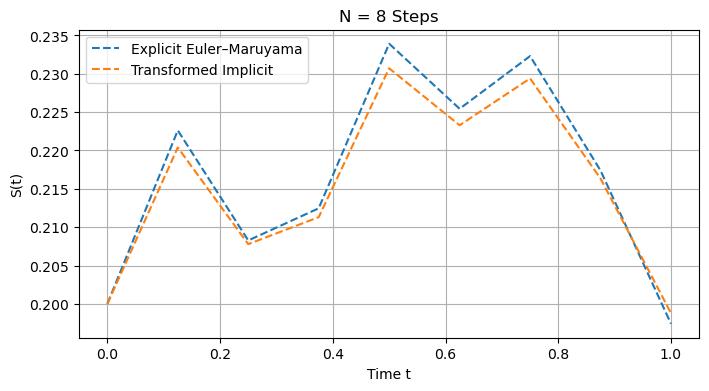

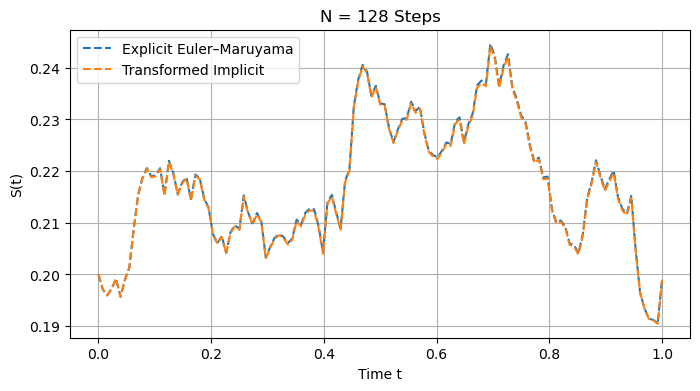

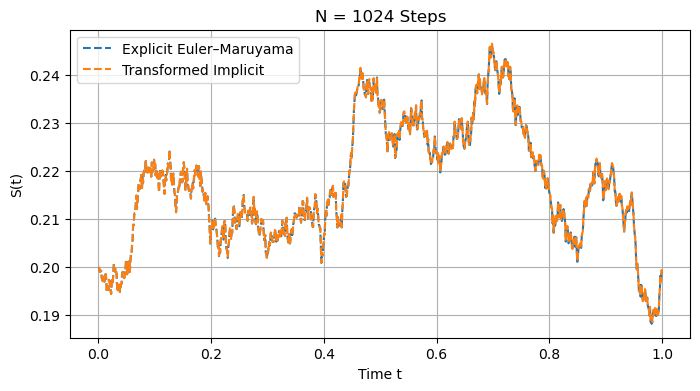

In [12]:
# Generate base Brownian path
N = 2**3
dt = T/N
inc = rng.normal(0, np.sqrt(dt), N)
W = np.insert(np.cumsum(inc), 0, 0)

# Brownian bridge function from lab
def b_bridge(t1, t, t2, x1, x2):
    Z = rng.normal(0, np.sqrt((t2-t)*(t-t1)/(t2-t1)), 1)
    return ((t2-t)*x1 + (t-t1)*x2)/(t2-t1) + Z[0]

# Plot trajectories at different resolutions
N_values = [2**3, 2**7, 2**10]
W_current = W

for N_val in N_values:
    if N_val > 2**3:  # If we need to refine the path
        # Double the points until we reach desired resolution
        while len(W_current) < N_val + 1:
            # Insert zeros between existing points
            W_new = np.insert(np.zeros(len(W_current)), np.arange(len(W_current)), W_current)[:-1]
            dt_new = T/(len(W_new)-1)
            t_new = np.arange(0, T+dt_new, dt_new)
            
            # Fill in points using Brownian bridge
            for i in range(1, len(W_new), 2):
                W_new[i] = b_bridge(t_new[i-1], t_new[i], t_new[i+1], W_new[i-1], W_new[i+1])
            
            W_current = W_new
    
    # Calculate increments from the path
    inc_current = np.diff(W_current)
    
    # Get approximations using these increments
    t_exp, S_explicit = explicit(N_val, inc_current)
    t_imp, S_implicit = implicit(N_val, inc_current)
    
    # Plot
    plt.figure(figsize=(8, 4))
    plt.plot(t_exp, S_explicit, '--', label='Explicit Euler–Maruyama')
    plt.plot(t_imp, S_implicit, '--', label='Transformed Implicit')
    plt.xlabel("Time t")
    plt.ylabel("S(t)")
    plt.title(f"N = {N_val} Steps")
    plt.legend()
    plt.grid(True)
    plt.show()

- It's pretty obvious from the plots that as N increases the two methods converge to the same solution
- This is expected as discretisation error decreases as N increases as we have a finer time grid


----------

### Question c

In [21]:
M_list = [10**z for z in range(2,6,1)]

In [22]:
exact_val = expected_value(kappa, lam, sigma, T)

In [23]:
results = []

In [24]:
## To speed up running this incorporate M into the functions we defined earlier for the impicit and explicit schemes. 
# can do this since looking at weka error and hence dont need to brownian bridge
def explicit_vec(N, M):
    dt = T / N
    # Generate all incs at once
    inc = np.random.normal(0, np.sqrt(dt), size=(M, N))
    S = np.empty((M, N+1))
    S[:, 0] = S0
    for i in range(N):
        S[:, i+1] = S[:, i] + dt*kappa*(lam - S[:, i]) \
                     + sigma*np.sqrt(np.abs(S[:, i])) * inc[:, i]
    return S[:, -1]

#do the same here
def implicit_vec(N, M):
    dt = T / N
    #generate incs for all M paths at once
    inc = np.random.normal(0, np.sqrt(dt), size=(M, N))
    Y = np.empty((M, N+1))
    Y[:, 0] = np.sqrt(S0)
    for i in range(N):
        term_1 = (Y[:, i] + gamma * inc[:, i]) / (2 * (1 - beta * dt))
        term_2 = np.sqrt((Y[:, i] + gamma * inc[:, i])**2 / (4 * (1 - beta * dt)**2) \
                         + (alpha * dt) / (1 - beta * dt))
        Y[:, i+1] = term_1 + term_2
    return Y[:, -1]**2


In [25]:
results = []
N_list = [2**k for k in [3,7,10]]
for N in N_list:
    for M in M_list:
        explicit_vals = explicit_vec(N, M)
        implicit_vals = implicit_vec(N, M)


        weak_error_explicit = np.abs(exact_val - np.mean(explicit_vals))
        weak_error_implicit = np.abs(exact_val - np.mean(implicit_vals))
        results.append({
            'N': N, 'StepSize': T/N, 'M': M,
            'Weak Error (Explicit)': weak_error_explicit,
            'Weak Error (Implicit)': weak_error_implicit
        })

df_errors = pd.DataFrame(results)


In [26]:
display(df_errors)


,N,StepSize,M,Weak Error (Explicit),Weak Error (Implicit)
0,8,0.125000,100,0.006803,0.000019
1,8,0.125000,1000,0.000203,0.001134
2,8,0.125000,10000,0.000473,0.000046
3,8,0.125000,100000,0.000058,0.000028
4,128,0.007812,100,0.001353,0.002774
5,128,0.007812,1000,0.000795,0.000786
6,128,0.007812,10000,0.000080,0.000386
7,128,0.007812,100000,0.000153,0.000056
8,1024,0.000977,100,0.000328,0.003136
9,1024,0.000977,1000,0.000292,0.001365


-------

### Question d

In [31]:
N_list = [2**k for k in range(3,10,1)]
results_plot = []
for N in N_list:
    for M in M_list:
        explicit_vals = explicit_vec(N, M)
        implicit_vals = implicit_vec(N, M)
        weak_error_explicit = np.abs(exact_val - np.mean(explicit_vals))
        weak_error_implicit = np.abs(exact_val - np.mean(implicit_vals))
        # Sample variance and std defor final values
        var_explicit = np.var(explicit_vals, ddof=1)
        sem_explicit = np.sqrt(var_explicit / M)
        var_implicit = np.var(implicit_vals, ddof=1)
        sem_implicit = np.sqrt(var_implicit / M)
        results_plot.append({
            'N': N, 
            'StepSize': T/N, 
            'M': M,
            'Weak Error (Explicit)': weak_error_explicit,
            'Weak Error (Implicit)': weak_error_implicit,
            'Std Error (Explicit)': sem_explicit,
            'Std Error (Implicit)': sem_implicit
        })


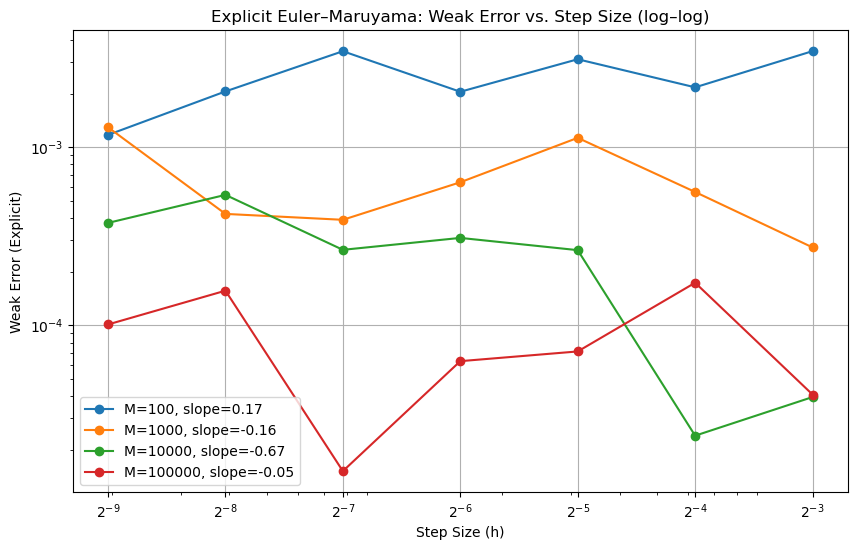

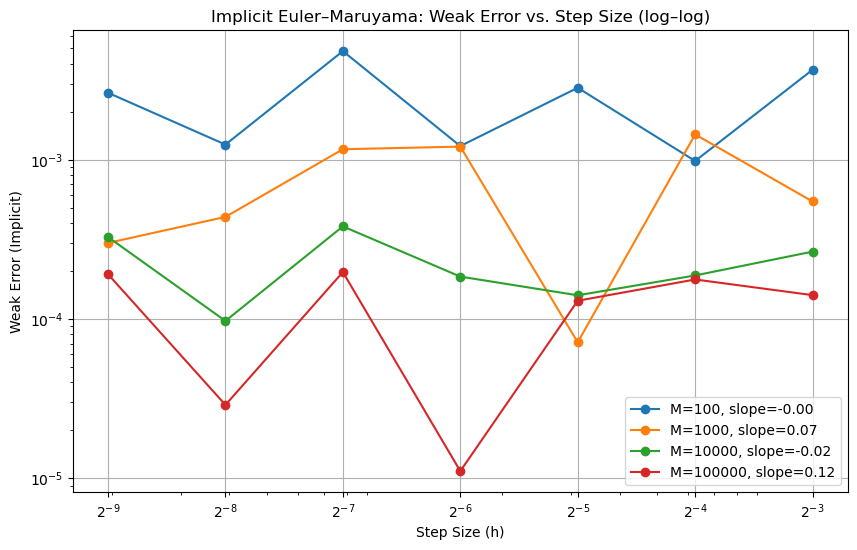

In [32]:
df_plot = pd.DataFrame(results_plot)

# Get the unique M values used
M_unique = sorted(df_plot['M'].unique())

# -----------------------------
# Plot for the Explicit Method
# -----------------------------
plt.figure(figsize=(10, 6))
for M in M_unique:
    # Filter results for this M, sort by step size
    subset = df_plot[df_plot['M'] == M].sort_values(by='StepSize')
    h_vals = subset['StepSize'].values
    errors_explicit = subset['Weak Error (Explicit)'].values
    
    # Compute slope for reference (in log-log space)
    slope_explicit = np.polyfit(np.log(h_vals), np.log(errors_explicit), 1)[0]
    
    # Plot in linear space (we'll switch the axes to log-scale below)
    plt.plot(h_vals, errors_explicit, 'o-', label=f"M={M}, slope={slope_explicit:.2f}")

#set both axes to log scale
plt.xscale("log")
plt.yscale("log")

#define tick positions for plot
h_tick_values = [2**(-k) for k in range(3, 10)]
h_tick_labels = [f"$2^{{-{k}}}$" for k in range(3, 10)]

plt.xticks(h_tick_values, h_tick_labels)

plt.xlabel("Step Size (h)")
plt.ylabel("Weak Error (Explicit)")
plt.title("Explicit Euler–Maruyama: Weak Error vs. Step Size (log–log)")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# Plot for the Implicit Method
# -----------------------------
plt.figure(figsize=(10, 6))
for M in M_unique:
    # Filter results for this M, sort by step size
    subset = df_plot[df_plot['M'] == M].sort_values(by='StepSize')
    h_vals = subset['StepSize'].values
    errors_implicit = subset['Weak Error (Implicit)'].values
    
    # Compute slope for reference (in log-log space)
    slope_implicit = np.polyfit(np.log(h_vals), np.log(errors_implicit), 1)[0]
    
    # Plot in linear space (we'll switch the axes to log-scale below)
    plt.plot(h_vals, errors_implicit, 'o-', label=f"M={M}, slope={slope_implicit:.2f}")

# Now set both axes to log scale
plt.xscale("log")
plt.yscale("log")

# Define tick positions (the actual h values) and corresponding labels (2^-3, 2^-4, etc.)
# For N in [8, 16, 32, 64, 128, 256, 512], h = 1/N = 2^-3, 2^-4, ..., 2^-9
h_tick_values = [2**(-k) for k in range(3, 10)]
h_tick_labels = [f"$2^{{-{k}}}$" for k in range(3, 10)]

plt.xticks(h_tick_values, h_tick_labels)

plt.xlabel("Step Size (h)")
plt.ylabel("Weak Error (Implicit)")
plt.title("Implicit Euler–Maruyama: Weak Error vs. Step Size (log–log)")
plt.legend()
plt.grid(True)
plt.show()

In [33]:
results_plot_df = pd.DataFrame(results_plot)

In [34]:
display(results_plot_df)

,N,StepSize,M,Weak Error (Explicit),Weak Error (Implicit),Std Error (Explicit),Std Error (Implicit)
0,8,0.125000,100,0.003465,0.003661,0.002832,0.002844
1,8,0.125000,1000,0.000274,0.000546,0.000915,0.000948
2,8,0.125000,10000,0.000040,0.000265,0.000305,0.000282
3,8,0.125000,100000,0.000041,0.000141,0.000098,0.000090
4,16,0.062500,100,0.002169,0.000980,0.003173,0.002749
5,16,0.062500,1000,0.000560,0.001438,0.000905,0.000908
6,16,0.062500,10000,0.000024,0.000187,0.000303,0.000288
7,16,0.062500,100000,0.000173,0.000177,0.000095,0.000091
8,32,0.031250,100,0.003119,0.002822,0.002975,0.002561
9,32,0.031250,1000,0.001129,0.000071,0.000925,0.000882


In [39]:
results_plot_df[results_plot_df['M'] == 100000]

,N,StepSize,M,Weak Error (Explicit),Weak Error (Implicit),Std Error (Explicit),Std Error (Implicit)
3,8,0.125000,100000,0.000071,0.000147,0.000097,0.000090
7,16,0.062500,100000,0.000053,0.000121,0.000095,0.000091
11,32,0.031250,100000,0.000053,0.000022,0.000094,0.000092
15,64,0.015625,100000,0.000057,0.000008,0.000093,0.000092
19,128,0.007812,100000,0.000037,0.000206,0.000093,0.000093
23,256,0.003906,100000,0.000130,0.000071,0.000093,0.000093
27,512,0.001953,100000,0.000057,0.000162,0.000093,0.000093


- We can see from the plots that the only cases when the explicit and implicit error is less than $10^{-4}$ is when $M = 10^5$.
- So now we want the smallest $N$ when both the implicit and explicit exhibit error less than $10^{-4}$ and that is $N = 2^5$ or when $h = 2^{-5}$, since $h = T/N$ and $T = 1$


## Question e

Computing strong errors for N=8...
Computing strong errors for N=16...
Computing strong errors for N=32...
Computing strong errors for N=64...
Computing strong errors for N=128...


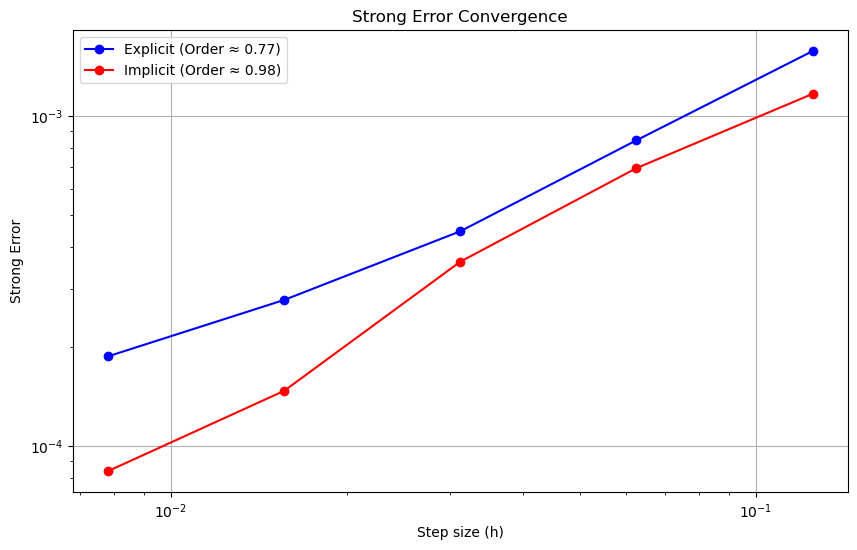


Strong Error Convergence Results:
  N        h  Strong Error (Explicit)  Strong Error (Implicit)
  8 0.125000                 0.001573                 0.001167
 16 0.062500                 0.000845                 0.000695
 32 0.031250                 0.000448                 0.000362
 64 0.015625                 0.000277                 0.000147
128 0.007812                 0.000187                 0.000084


In [35]:
def compute_strong_errors(N_values, M, N_ref=2**12):
    results = []
    
    for N in N_values:
        print(f"Computing strong errors for N={N}...")
        explicit_errors = np.zeros(M)
        implicit_errors = np.zeros(M)
        
        for m in range(M):
            # Generate base path at coarse resolution
            dt = T/N
            inc_base = rng.normal(0, np.sqrt(dt), N)
            W_base = np.insert(np.cumsum(inc_base), 0, 0)
            W_current = W_base
            
            # Refine the path using Brownian bridge (similar to your previous code)
            while len(W_current) < N_ref + 1:
                # Insert zeros between existing points
                W_new = np.insert(np.zeros(len(W_current)), np.arange(len(W_current)), W_current)[:-1]
                dt_new = T/(len(W_new)-1)
                t_new = np.arange(0, T+dt_new, dt_new)
                
                # Fill in points using Brownian bridge
                for i in range(1, len(W_new), 2):
                    W_new[i] = b_bridge(t_new[i-1], t_new[i], t_new[i+1], W_new[i-1], W_new[i+1])
                
                W_current = W_new
            
            # Calculate increments for both resolutions
            inc_ref = np.diff(W_current)  # For reference solution
            inc_base = np.diff(W_base)    # For approximate solution
            
            # Generate reference solutions
            _, S_ref_explicit = explicit(N_ref, inc_ref) #can ignore the time grid the function returns
            _, S_ref_implicit = implicit(N_ref, inc_ref)
            
            # Generate approximate solutions
            _, S_approx_explicit = explicit(N, inc_base)
            _, S_approx_implicit = implicit(N, inc_base)
            
            # Compute strong errors at terminal time
            explicit_errors[m] = abs(S_ref_explicit[-1] - S_approx_explicit[-1])
            implicit_errors[m] = abs(S_ref_implicit[-1] - S_approx_implicit[-1])
        
        # Average strong errors over all paths
        mean_explicit_error = np.mean(explicit_errors)
        mean_implicit_error = np.mean(implicit_errors)
        
        results.append({
            'N': N,
            'h': T/N,
            'Strong Error (Explicit)': mean_explicit_error,
            'Strong Error (Implicit)': mean_implicit_error
        })
    
    return pd.DataFrame(results)

# Compute strong errors
N_values = [2**k for k in range(3, 8)]  # Test N = 8, 16, 32, 64, 128
M = 100  # Number of paths
strong_errors = compute_strong_errors(N_values, M)

# Plot strong error convergence
plt.figure(figsize=(10, 6))

# Plot explicit method errors
h_values = strong_errors['h']
explicit_errors = strong_errors['Strong Error (Explicit)']
implicit_errors = strong_errors['Strong Error (Implicit)']

# Fit lines in log-log space
z_explicit = np.polyfit(np.log(h_values), np.log(explicit_errors), 1)
z_implicit = np.polyfit(np.log(h_values), np.log(implicit_errors), 1)

plt.loglog(h_values, explicit_errors, 'bo-', label=f'Explicit (Order ≈ {abs(z_explicit[0]):.2f})')
plt.loglog(h_values, implicit_errors, 'ro-', label=f'Implicit (Order ≈ {abs(z_implicit[0]):.2f})')

plt.xlabel('Step size (h)')
plt.ylabel('Strong Error')
plt.title('Strong Error Convergence')
plt.grid(True)
plt.legend()
plt.show()

# Print results table
print("\nStrong Error Convergence Results:")
print(strong_errors.to_string(index=False))

# Strong Error Convergence Strategy

To estimate the strong error for each method despite the lack of a closed-form pathwise solution, we compare each discretised solution on a coarse step size $h=T/N$ to a reference solution computed with a much finer step size $h_{ref}=T/N_{ref}$.

## 1. Generate a Fine "Reference" Brownian Path
- Pick $N_{ref} \gg N$ (e.g. $2^{12}$)
- For each of $M$ independent simulations, build a Brownian motion on that fine grid, obtaining increments $\Delta B_{ref,i}$

## 2. Reference Solution
- For each of those $M$ paths, apply the same scheme $(3)$ or $(5)$ with $N_{ref}$ steps to get $S_{ref}(T,\omega)$
- This is treated as "ground truth" for that path $\omega$

## 3. Coarse Discretisation on the Same Path
- For each $N$, we create a base Brownian path with $N$ steps
- We then refine this path to $N_{ref}$ points using Brownian bridge:
  - At each step, we add new points between existing ones
  - Each new point is calculated using the Brownian bridge formula
  - We repeat this until we have $N_{ref}$ points
- This means both the coarse solution $S_N$ and reference solution $S_{ref}$ use the same Brownian motion, just sampled at different time points

## 4. Compute the Pathwise Error
- For each path $\omega$, measure $|S_{ref}(T,\omega)-S_N(T,\omega)|$
- Average over the $M$ simulations to estimate the strong error:
  $$E[|S_{ref}-S_N|] \approx \frac{1}{M}\sum_{j=1}^M |S_{ref}^{(j)}-S_N^{(j)}|$$

## 5. Convergence Rate
- We plot the strong error vs. $h$ on a log-log scale
- Theoretically, both methods $(3)$ and $(5)$ should exhibit order $\frac{1}{2}$ strong convergence, though practical slopes can deviate if $N$ is not large enough or if parameter choices affect transients
  - This $\frac{1}{2}$ order comes from the fact that the error is dominated by the Brownian increments, which scale as $\sqrt{h}$ due to the properties of Brownian motion
  - The Euler-Maruyama method (3) and the implicit method (5) both approximate the stochastic integral with this same fundamental scaling

Thus, even without an explicit pathwise solution, we can produce a strong error convergence plot by treating the fine-grid solution as an approximate exact solution and ensuring each coarse scheme uses the same Brownian sample for a consistent pathwise comparison.